In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [4]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [6]:
runs = [304125,302263,304508]

WINDOW = 5

with open("unscaled_data_WINDOW" + str(WINDOW) + ".pickle", 'rb') as handle:
    data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224


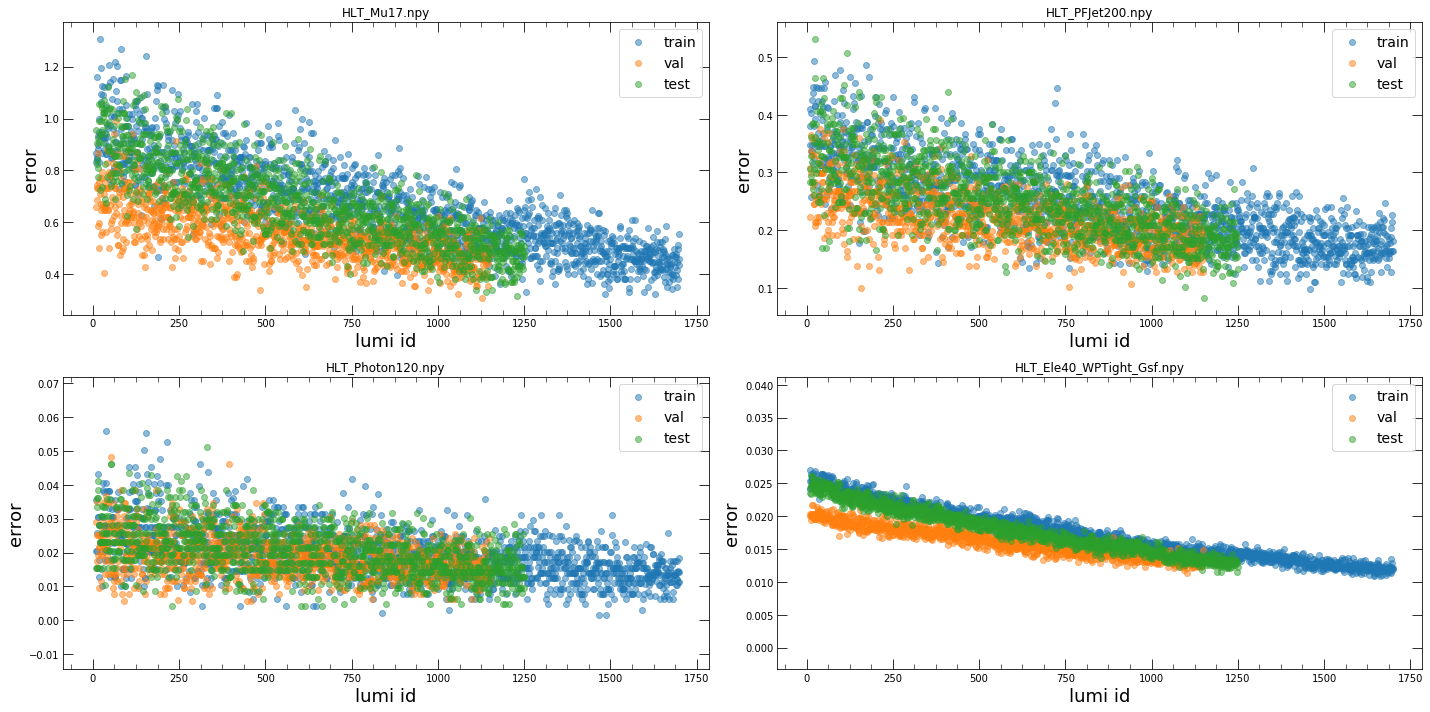

In [7]:
plots = [x_train,x_val,x_test]
titles = ["train","val","test"]

stuff = [[],[],[]]
lumi = [[],[],[]]
for h in range(3):
    labels = data['HLT'] 
    lumi[h] = data[str(runs[h])]['lumiid']
    stuff[h] = data[str(runs[h])]['rates']
    
plt.figure(figsize=[20,10])
              
for i in range(4):
    plt.subplot(2,2,i+1)
    for k in range(0,3):
        print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

## Simple Autoencoder

In [8]:
model_name = "simplest_" + str(WINDOW)

In [9]:
# Define the architecture

_input = Input(shape=(4*WINDOW,), name="input")

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="encoded")(_input)

output = Dense(4*WINDOW,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(hidden)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 20)                0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 63        
_________________________________________________________________
reconstructed (Dense)        (None, 20)                80        
Total params: 143
Trainable params: 143
Non-trainable params: 0
_________________________________________________________________


Train on 1665 samples, validate on 1125 samples
Epoch 1/1000
 - 0s - loss: 203.6537 - val_loss: 143.6766
Epoch 2/1000
 - 0s - loss: 198.7001 - val_loss: 140.1861
Epoch 3/1000
 - 0s - loss: 193.9003 - val_loss: 136.8141
Epoch 4/1000
 - 0s - loss: 189.2348 - val_loss: 133.4963
Epoch 5/1000
 - 0s - loss: 184.6187 - val_loss: 130.2131
Epoch 6/1000
 - 0s - loss: 180.0760 - val_loss: 127.0005
Epoch 7/1000
 - 0s - loss: 175.6315 - val_loss: 123.8596
Epoch 8/1000
 - 0s - loss: 171.2798 - val_loss: 120.7907
Epoch 9/1000
 - 0s - loss: 167.0307 - val_loss: 117.7937
Epoch 10/1000
 - 0s - loss: 162.8863 - val_loss: 114.8680
Epoch 11/1000
 - 0s - loss: 158.8516 - val_loss: 112.0136
Epoch 12/1000
 - 0s - loss: 154.8783 - val_loss: 109.2320
Epoch 13/1000
 - 0s - loss: 151.0469 - val_loss: 106.5190
Epoch 14/1000
 - 0s - loss: 147.3030 - val_loss: 103.8758
Epoch 15/1000
 - 0s - loss: 143.6397 - val_loss: 101.2877
Epoch 16/1000
 - 0s - loss: 140.0784 - val_loss: 98.7823
Epoch 17/1000
 - 0s - loss: 136.59

Epoch 146/1000
 - 0s - loss: 11.1042 - val_loss: 7.8941
Epoch 147/1000
 - 0s - loss: 10.9411 - val_loss: 7.7784
Epoch 148/1000
 - 0s - loss: 10.7808 - val_loss: 7.6647
Epoch 149/1000
 - 0s - loss: 10.6233 - val_loss: 7.5532
Epoch 150/1000
 - 0s - loss: 10.4689 - val_loss: 7.4435
Epoch 151/1000
 - 0s - loss: 10.3169 - val_loss: 7.3358
Epoch 152/1000
 - 0s - loss: 10.1676 - val_loss: 7.2301
Epoch 153/1000
 - 0s - loss: 10.0213 - val_loss: 7.1261
Epoch 154/1000
 - 0s - loss: 9.8775 - val_loss: 7.0240
Epoch 155/1000
 - 0s - loss: 9.7362 - val_loss: 6.9237
Epoch 156/1000
 - 0s - loss: 9.5971 - val_loss: 6.8252
Epoch 157/1000
 - 0s - loss: 9.4600 - val_loss: 6.7283
Epoch 158/1000
 - 0s - loss: 9.3262 - val_loss: 6.6332
Epoch 159/1000
 - 0s - loss: 9.1954 - val_loss: 6.5397
Epoch 160/1000
 - 0s - loss: 9.0651 - val_loss: 6.4479
Epoch 161/1000
 - 0s - loss: 8.9385 - val_loss: 6.3576
Epoch 162/1000
 - 0s - loss: 8.8133 - val_loss: 6.2690
Epoch 163/1000
 - 0s - loss: 8.6902 - val_loss: 6.1820
Ep

Epoch 295/1000
 - 0s - loss: 1.8774 - val_loss: 1.3388
Epoch 296/1000
 - 0s - loss: 1.8591 - val_loss: 1.3258
Epoch 297/1000
 - 0s - loss: 1.8411 - val_loss: 1.3130
Epoch 298/1000
 - 0s - loss: 1.8234 - val_loss: 1.3003
Epoch 299/1000
 - 0s - loss: 1.8059 - val_loss: 1.2878
Epoch 300/1000
 - 0s - loss: 1.7884 - val_loss: 1.2755
Epoch 301/1000
 - 0s - loss: 1.7713 - val_loss: 1.2632
Epoch 302/1000
 - 0s - loss: 1.7544 - val_loss: 1.2512
Epoch 303/1000
 - 0s - loss: 1.7376 - val_loss: 1.2393
Epoch 304/1000
 - 0s - loss: 1.7210 - val_loss: 1.2275
Epoch 305/1000
 - 0s - loss: 1.7048 - val_loss: 1.2158
Epoch 306/1000
 - 0s - loss: 1.6885 - val_loss: 1.2043
Epoch 307/1000
 - 0s - loss: 1.6726 - val_loss: 1.1929
Epoch 308/1000
 - 0s - loss: 1.6567 - val_loss: 1.1816
Epoch 309/1000
 - 0s - loss: 1.6411 - val_loss: 1.1705
Epoch 310/1000
 - 0s - loss: 1.6257 - val_loss: 1.1595
Epoch 311/1000
 - 0s - loss: 1.6105 - val_loss: 1.1486
Epoch 312/1000
 - 0s - loss: 1.5954 - val_loss: 1.1378
Epoch 313/

Epoch 444/1000
 - 0s - loss: 0.5342 - val_loss: 0.3807
Epoch 445/1000
 - 0s - loss: 0.5303 - val_loss: 0.3780
Epoch 446/1000
 - 0s - loss: 0.5264 - val_loss: 0.3752
Epoch 447/1000
 - 0s - loss: 0.5226 - val_loss: 0.3724
Epoch 448/1000
 - 0s - loss: 0.5188 - val_loss: 0.3697
Epoch 449/1000
 - 0s - loss: 0.5150 - val_loss: 0.3670
Epoch 450/1000
 - 0s - loss: 0.5113 - val_loss: 0.3643
Epoch 451/1000
 - 0s - loss: 0.5075 - val_loss: 0.3617
Epoch 452/1000
 - 0s - loss: 0.5039 - val_loss: 0.3591
Epoch 453/1000
 - 0s - loss: 0.5002 - val_loss: 0.3564
Epoch 454/1000
 - 0s - loss: 0.4966 - val_loss: 0.3539
Epoch 455/1000
 - 0s - loss: 0.4930 - val_loss: 0.3513
Epoch 456/1000
 - 0s - loss: 0.4895 - val_loss: 0.3488
Epoch 457/1000
 - 0s - loss: 0.4859 - val_loss: 0.3463
Epoch 458/1000
 - 0s - loss: 0.4825 - val_loss: 0.3438
Epoch 459/1000
 - 0s - loss: 0.4790 - val_loss: 0.3413
Epoch 460/1000
 - 0s - loss: 0.4756 - val_loss: 0.3388
Epoch 461/1000
 - 0s - loss: 0.4721 - val_loss: 0.3364
Epoch 462/

Epoch 593/1000
 - 0s - loss: 0.1995 - val_loss: 0.1416
Epoch 594/1000
 - 0s - loss: 0.1983 - val_loss: 0.1408
Epoch 595/1000
 - 0s - loss: 0.1972 - val_loss: 0.1399
Epoch 596/1000
 - 0s - loss: 0.1960 - val_loss: 0.1391
Epoch 597/1000
 - 0s - loss: 0.1948 - val_loss: 0.1383
Epoch 598/1000
 - 0s - loss: 0.1937 - val_loss: 0.1374
Epoch 599/1000
 - 0s - loss: 0.1926 - val_loss: 0.1366
Epoch 600/1000
 - 0s - loss: 0.1914 - val_loss: 0.1358
Epoch 601/1000
 - 0s - loss: 0.1903 - val_loss: 0.1350
Epoch 602/1000
 - 0s - loss: 0.1892 - val_loss: 0.1342
Epoch 603/1000
 - 0s - loss: 0.1881 - val_loss: 0.1334
Epoch 604/1000
 - 0s - loss: 0.1870 - val_loss: 0.1326
Epoch 605/1000
 - 0s - loss: 0.1859 - val_loss: 0.1319
Epoch 606/1000
 - 0s - loss: 0.1848 - val_loss: 0.1311
Epoch 607/1000
 - 0s - loss: 0.1837 - val_loss: 0.1303
Epoch 608/1000
 - 0s - loss: 0.1826 - val_loss: 0.1295
Epoch 609/1000
 - 0s - loss: 0.1816 - val_loss: 0.1288
Epoch 610/1000
 - 0s - loss: 0.1805 - val_loss: 0.1280
Epoch 611/

Epoch 742/1000
 - 0s - loss: 0.0890 - val_loss: 0.0627
Epoch 743/1000
 - 0s - loss: 0.0886 - val_loss: 0.0623
Epoch 744/1000
 - 0s - loss: 0.0881 - val_loss: 0.0620
Epoch 745/1000
 - 0s - loss: 0.0877 - val_loss: 0.0617
Epoch 746/1000
 - 0s - loss: 0.0873 - val_loss: 0.0614
Epoch 747/1000
 - 0s - loss: 0.0869 - val_loss: 0.0611
Epoch 748/1000
 - 0s - loss: 0.0864 - val_loss: 0.0608
Epoch 749/1000
 - 0s - loss: 0.0860 - val_loss: 0.0605
Epoch 750/1000
 - 0s - loss: 0.0856 - val_loss: 0.0602
Epoch 751/1000
 - 0s - loss: 0.0852 - val_loss: 0.0599
Epoch 752/1000
 - 0s - loss: 0.0848 - val_loss: 0.0596
Epoch 753/1000
 - 0s - loss: 0.0843 - val_loss: 0.0593
Epoch 754/1000
 - 0s - loss: 0.0839 - val_loss: 0.0590
Epoch 755/1000
 - 0s - loss: 0.0835 - val_loss: 0.0587
Epoch 756/1000
 - 0s - loss: 0.0831 - val_loss: 0.0585
Epoch 757/1000
 - 0s - loss: 0.0827 - val_loss: 0.0582
Epoch 758/1000
 - 0s - loss: 0.0823 - val_loss: 0.0579
Epoch 759/1000
 - 0s - loss: 0.0819 - val_loss: 0.0576
Epoch 760/

Epoch 891/1000
 - 0s - loss: 0.0453 - val_loss: 0.0315
Epoch 892/1000
 - 0s - loss: 0.0451 - val_loss: 0.0313
Epoch 893/1000
 - 0s - loss: 0.0449 - val_loss: 0.0312
Epoch 894/1000
 - 0s - loss: 0.0447 - val_loss: 0.0311
Epoch 895/1000
 - 0s - loss: 0.0445 - val_loss: 0.0309
Epoch 896/1000
 - 0s - loss: 0.0443 - val_loss: 0.0308
Epoch 897/1000
 - 0s - loss: 0.0442 - val_loss: 0.0307
Epoch 898/1000
 - 0s - loss: 0.0440 - val_loss: 0.0305
Epoch 899/1000
 - 0s - loss: 0.0438 - val_loss: 0.0304
Epoch 900/1000
 - 0s - loss: 0.0436 - val_loss: 0.0303
Epoch 901/1000
 - 0s - loss: 0.0434 - val_loss: 0.0302
Epoch 902/1000
 - 0s - loss: 0.0433 - val_loss: 0.0300
Epoch 903/1000
 - 0s - loss: 0.0431 - val_loss: 0.0299
Epoch 904/1000
 - 0s - loss: 0.0429 - val_loss: 0.0298
Epoch 905/1000
 - 0s - loss: 0.0427 - val_loss: 0.0297
Epoch 906/1000
 - 0s - loss: 0.0425 - val_loss: 0.0295
Epoch 907/1000
 - 0s - loss: 0.0424 - val_loss: 0.0294
Epoch 908/1000
 - 0s - loss: 0.0422 - val_loss: 0.0293
Epoch 909/

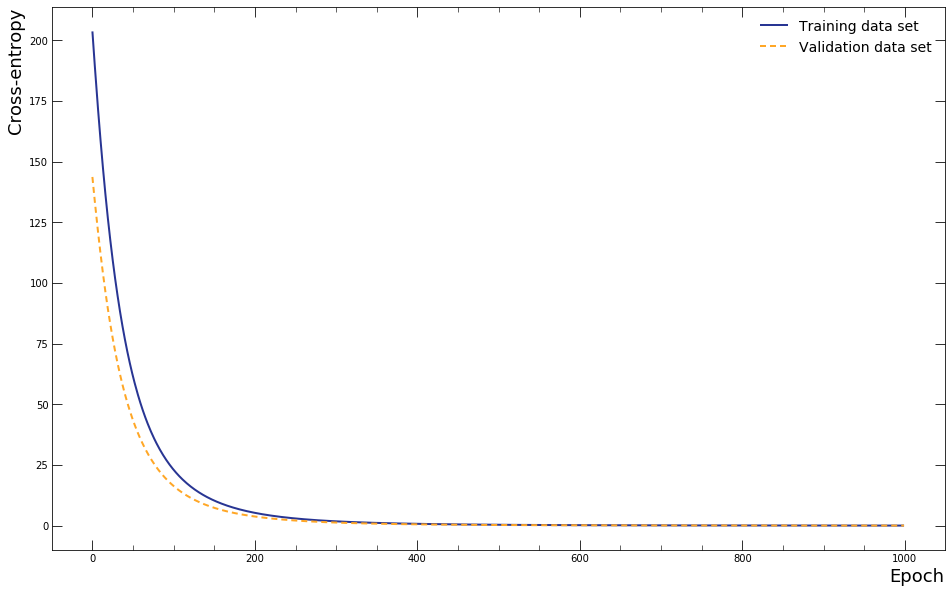

In [10]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

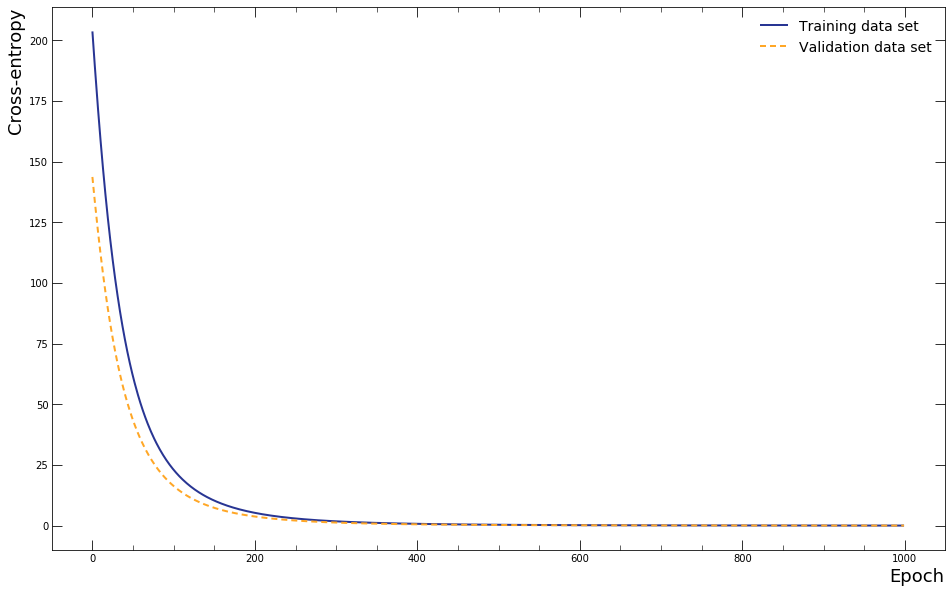

In [11]:
plot_loss(history)

## Training Data

In [12]:
# Generate predictions

model = load_model("%s.h5" % (model_name))
                
reconstructed = model.predict(np.array(x_train))

error = abs(x_train-reconstructed)/x_train

In [13]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_train[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_train[i][WINDOW*j])

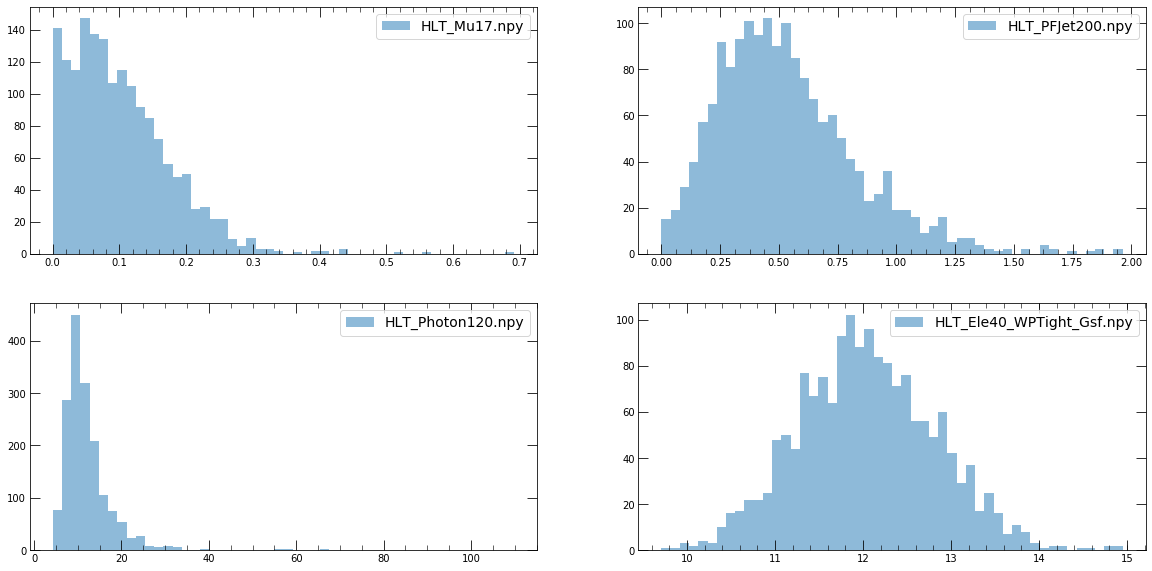

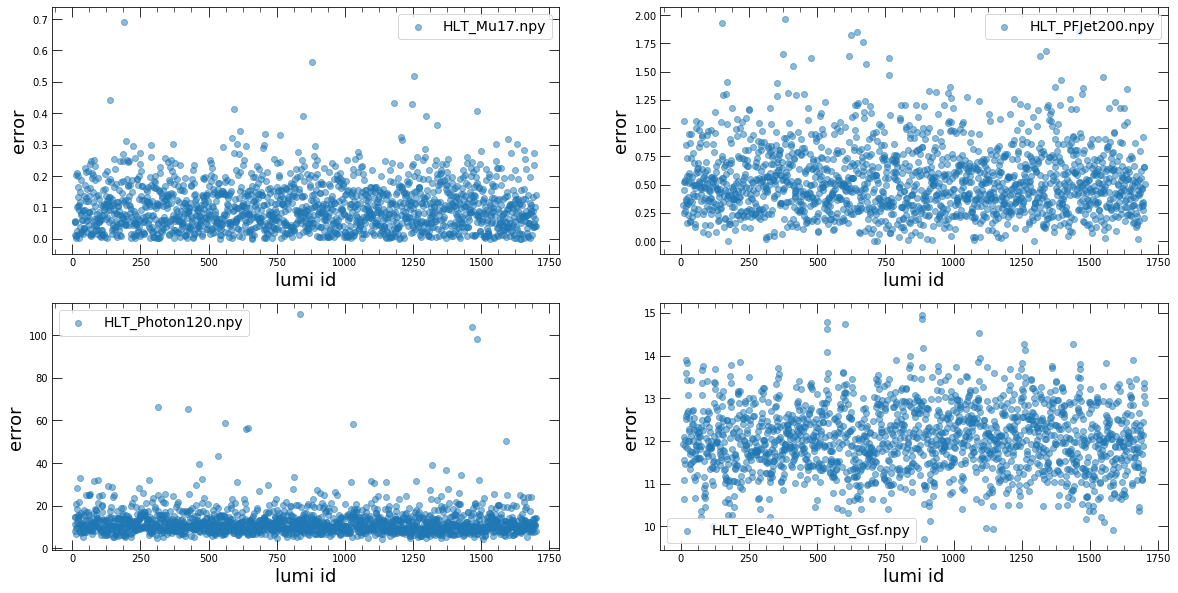

In [14]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[0])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

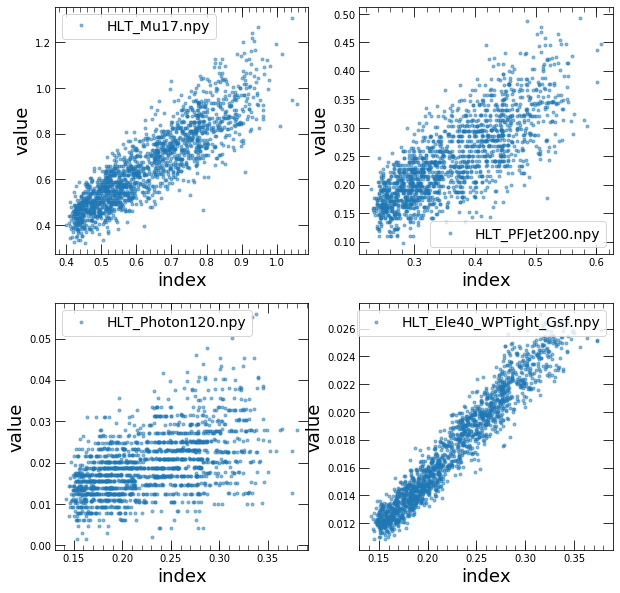

In [15]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

## Test Data

In [16]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [17]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_test_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_test_new[i][WINDOW*j])

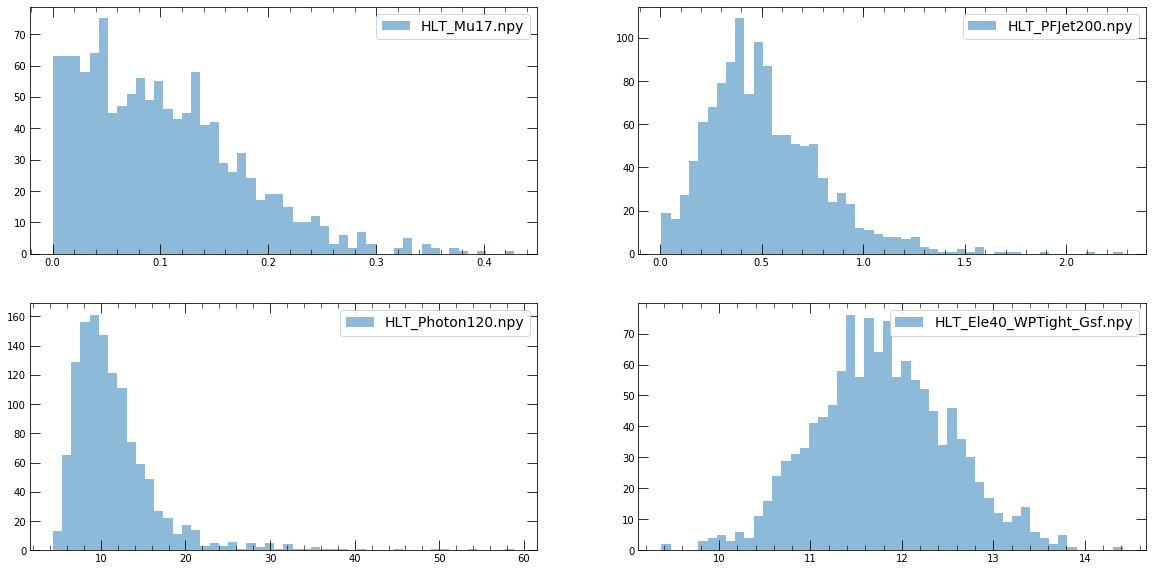

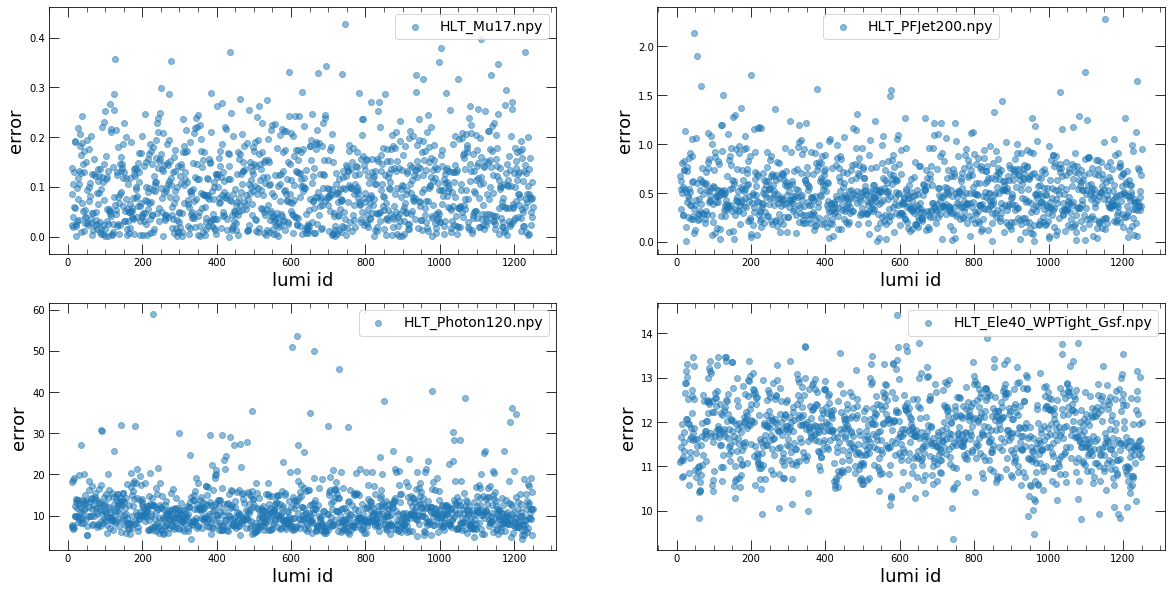

In [18]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

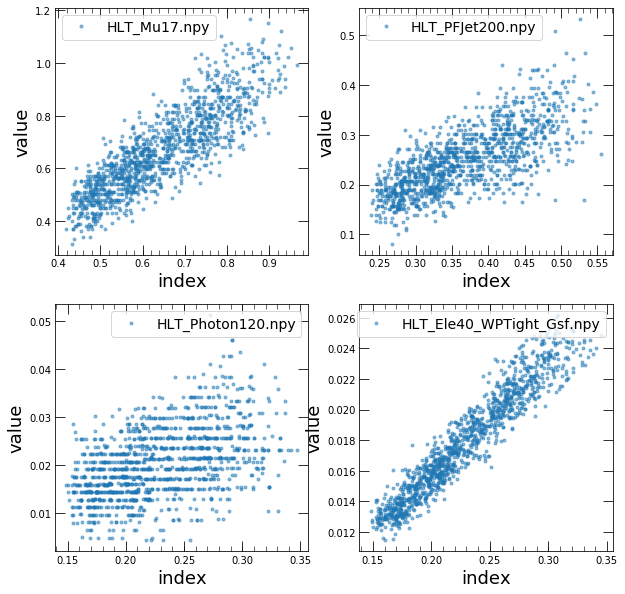

In [19]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

In [20]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [21]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [22]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [23]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [24]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1224 1224


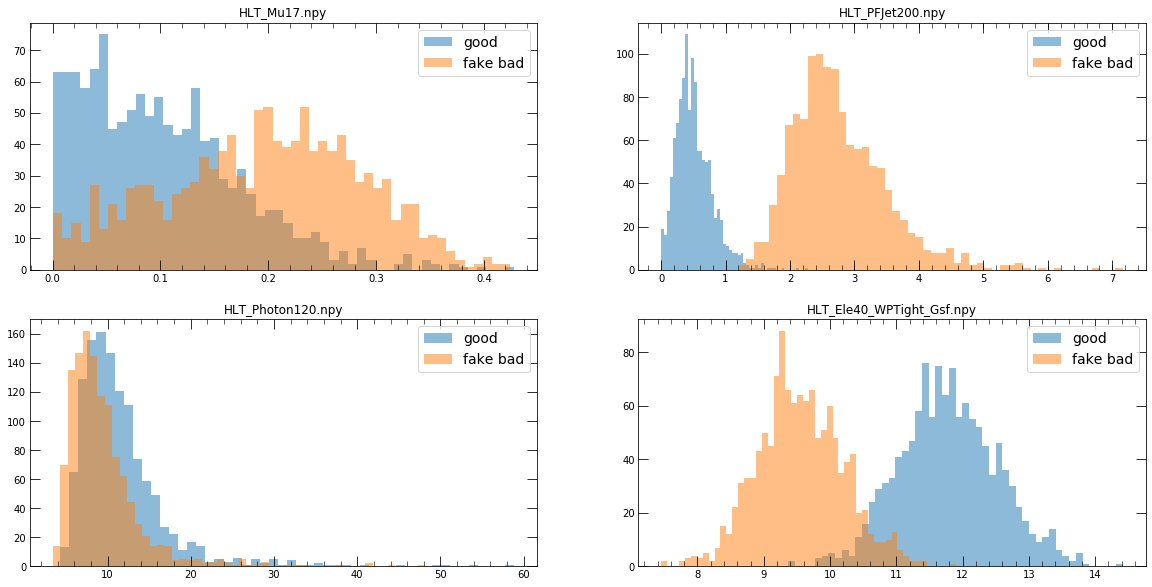

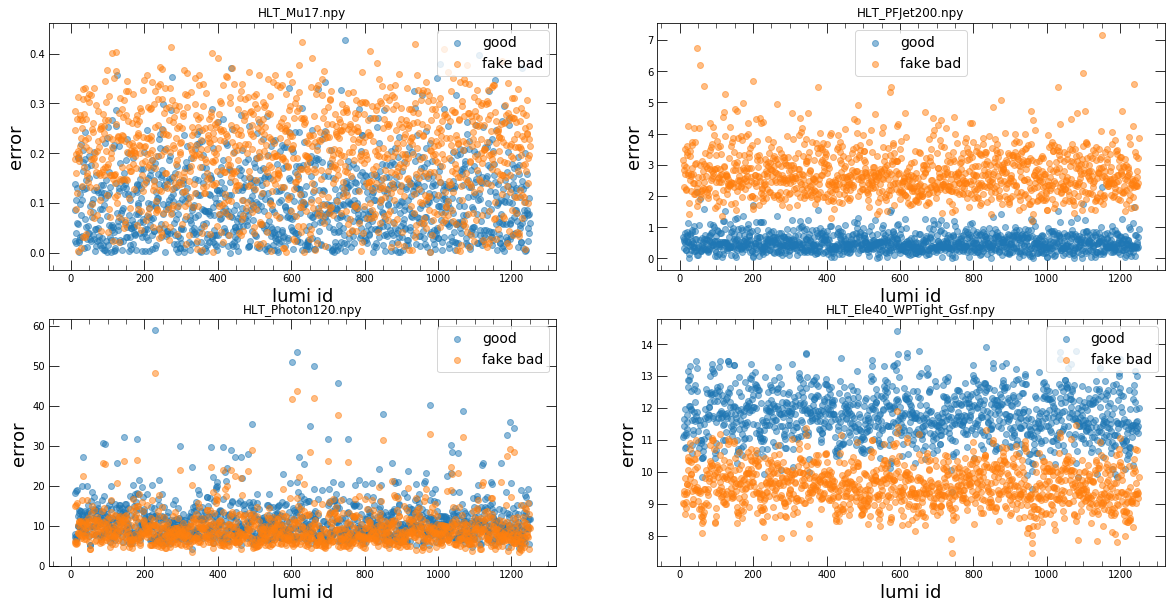

In [25]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

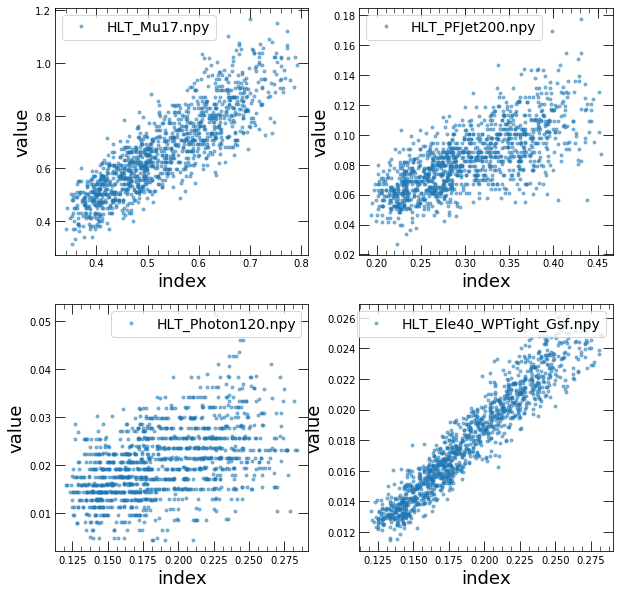

In [26]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()    

plt.show()

In [27]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [28]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [29]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [30]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [31]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1224 1224 1224


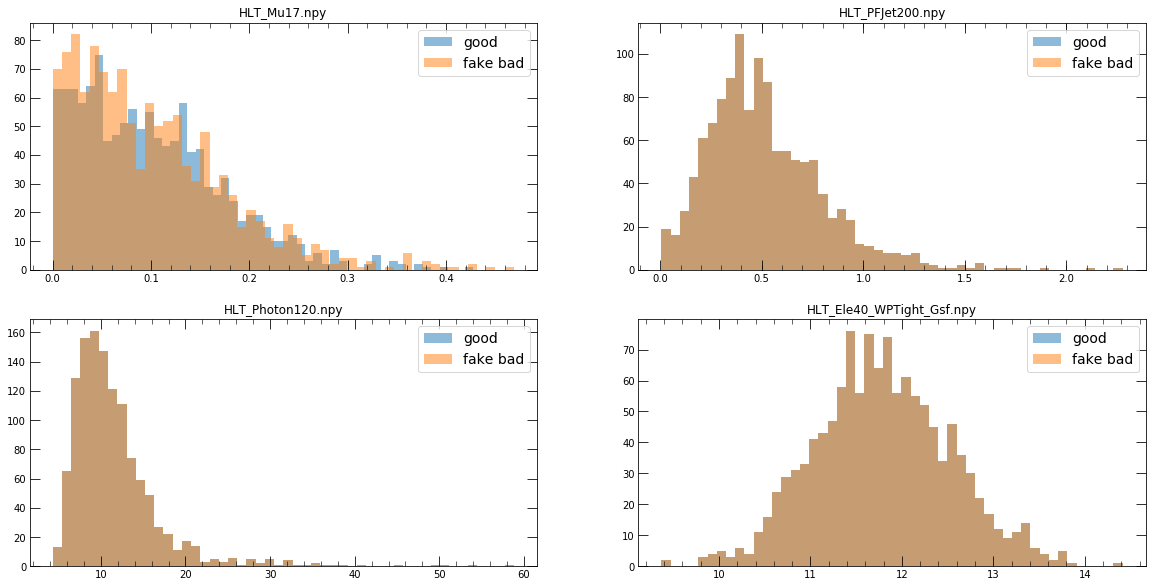

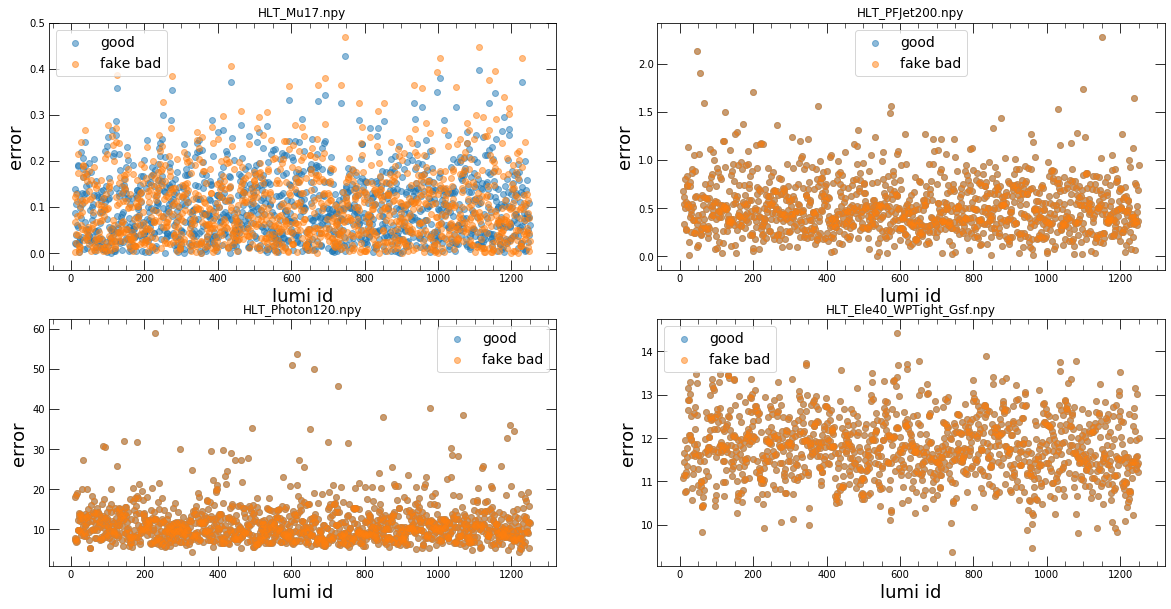

In [32]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(error_reformat[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

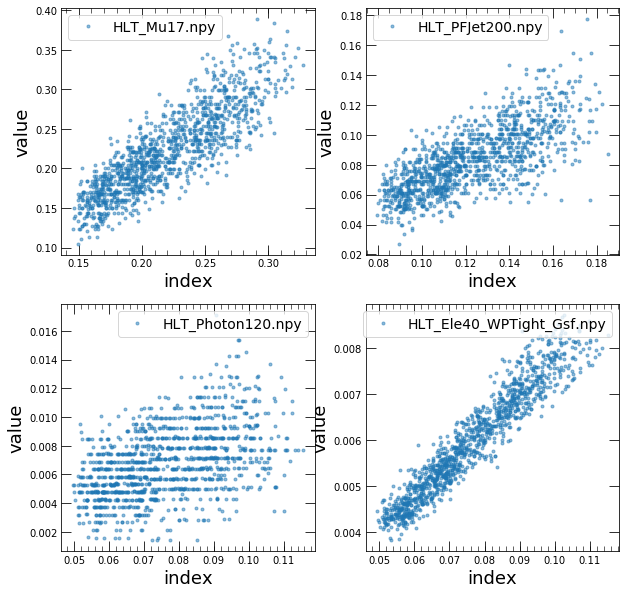

In [33]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

In [34]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [35]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [36]:
bad_runs = [301480]

with open("unscaled_bad_data_WINDOW" + str(WINDOW) + ".pickle", 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [37]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [38]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

154 154


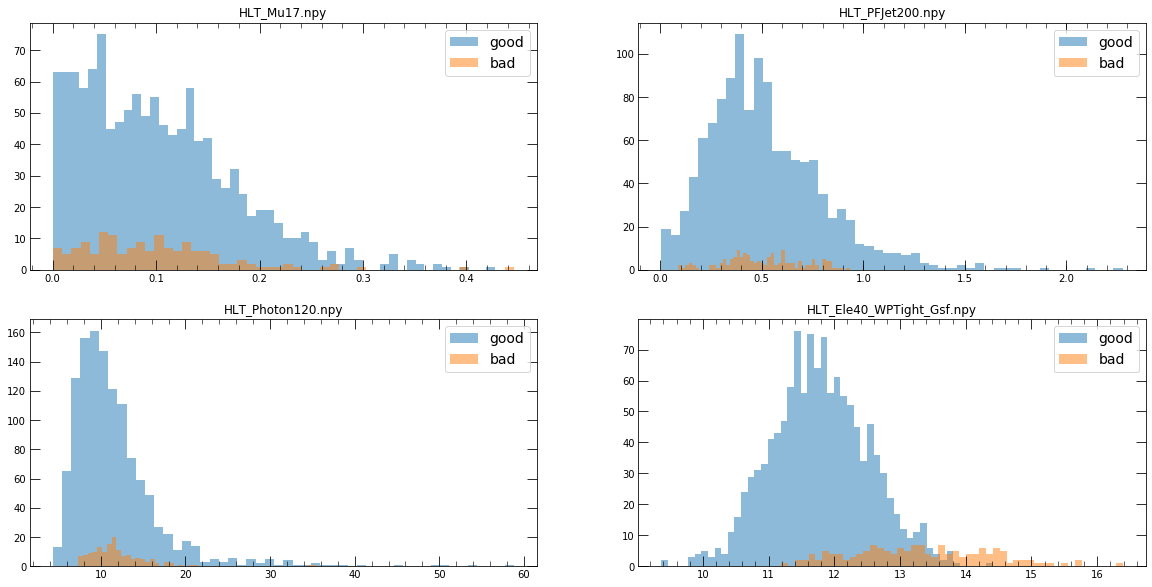

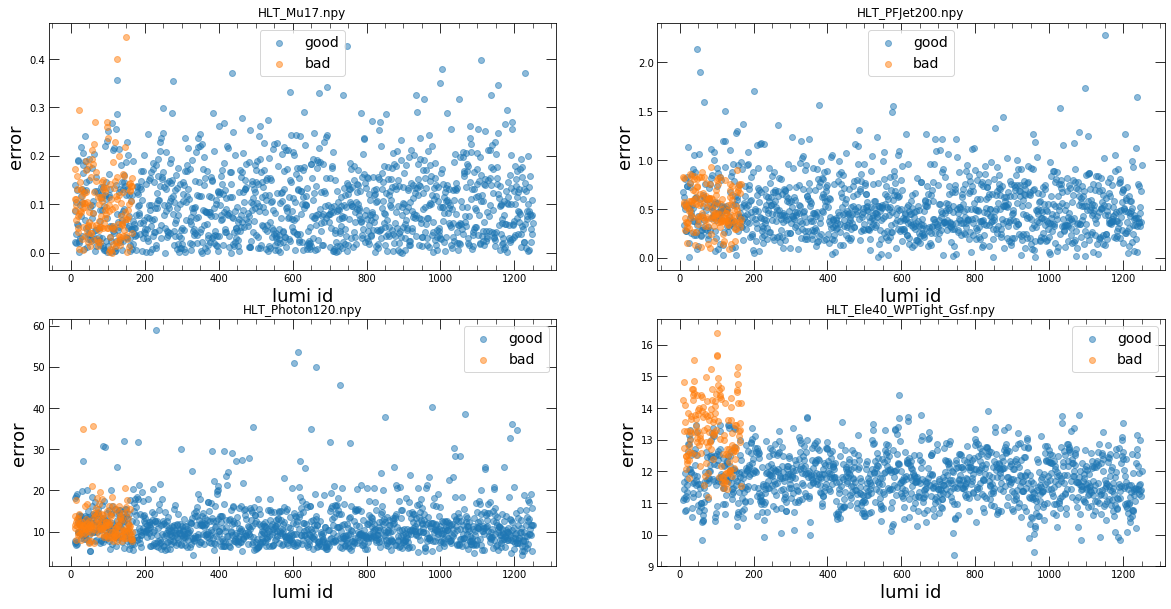

In [39]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

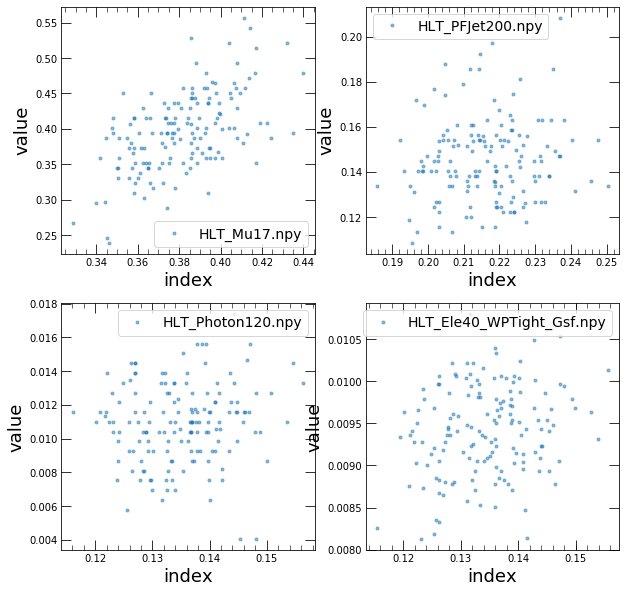

In [40]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

## Real Bad Data

In [43]:
bad_runs = [305588]

with open("unscaled_bad_data_WINDOW" + str(WINDOW) + ".pickle", 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [44]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [45]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

99 99


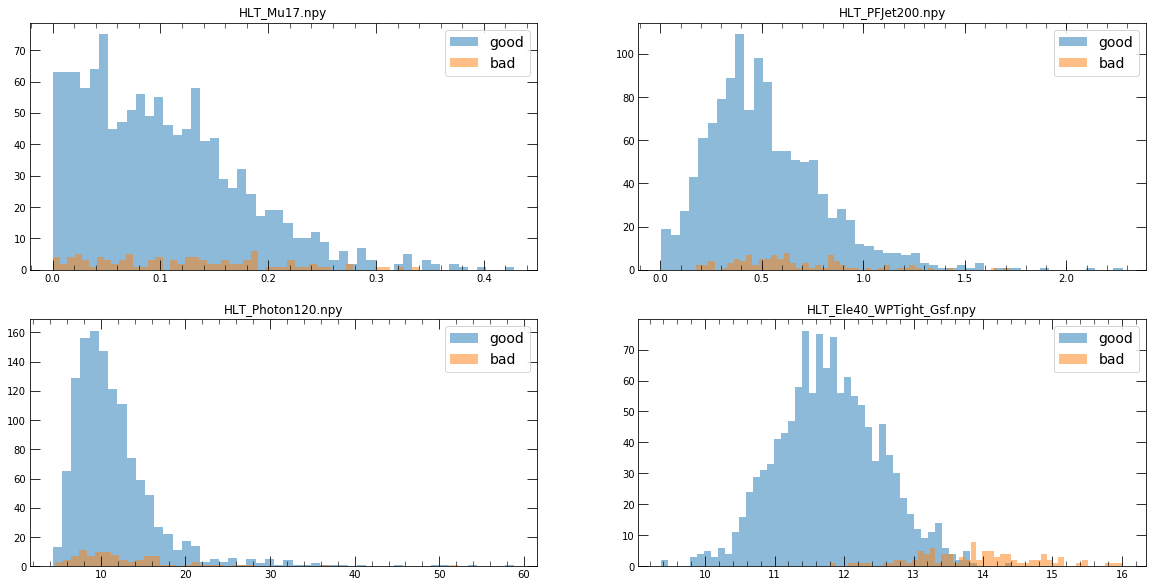

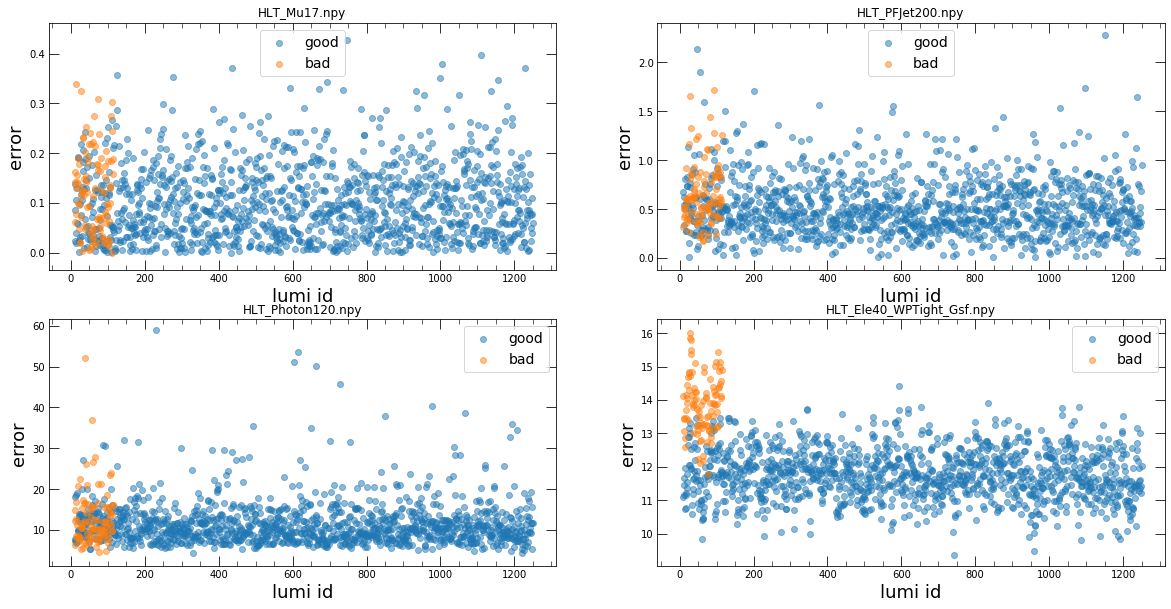

In [46]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

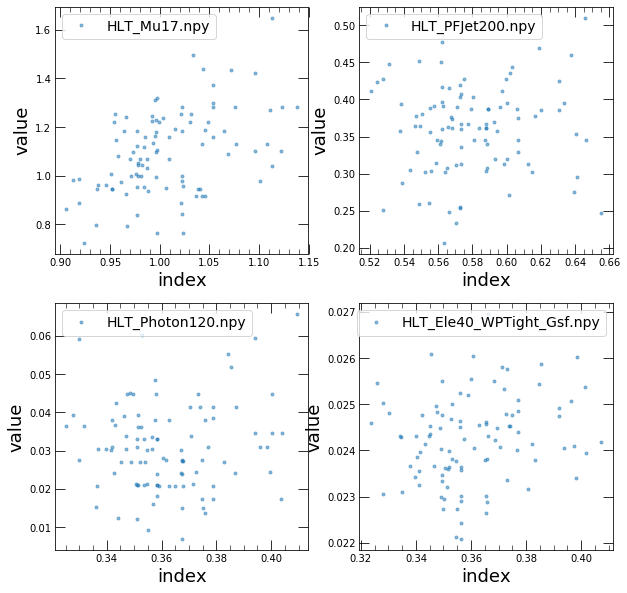

In [47]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()